In [120]:
import numpy as np
import pandas as pd
import random
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, LeakyReLU
from tensorflow.keras.regularizers import l2, l1_l2
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import mstats
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from bayes_opt import BayesianOptimization

In [121]:
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

In [122]:
df = pd.read_csv('../../data/pre_train/aapl.csv')
df.columns = df.columns.str.lower()
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')
df = df.astype(float)

In [123]:
y = df['log_close']
X = df.drop('log_close', axis=1)

In [124]:
time_steps = 67
def create_sequences(X, y, time_steps=time_steps):
    X_seq, y_seq = [], []
    for i in range(len(X) - time_steps):
        X_seq.append(X.iloc[i:i + time_steps].values)
        y_seq.append(y.iloc[i + time_steps])
    return np.array(X_seq), np.array(y_seq)

In [125]:
def evaluate_model(y_pred_train, y_pred_test, y_train, y_test):
    mae_train = mean_absolute_error(y_train, y_pred_train)
    mae_test = mean_absolute_error(y_test, y_pred_test)
    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)
    
    print(f"MAE train: {mae_train:.6f}")
    print(f"MAE test: {mae_test:.6f}")
    print(f"RMSE train: {rmse_train:.6f}")
    print(f"RMSE test: {rmse_test:.6f}")
    print(f"R² train: {r2_train:.6f}")
    print(f"R² test: {r2_test:.6f}")

In [126]:
def plot_predictions(y_test_real, y_pred_test_real):
    plt.figure(figsize=(12, 6))
    plt.plot(y_test_real, label="Real", color="blue")
    plt.plot(y_pred_test_real, label="Predicho", color="orange")
    plt.title("Predictions vs Real values")
    plt.legend()
    plt.show()

In [127]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [128]:
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

In [129]:
X_train_seq, y_train_seq = create_sequences(pd.DataFrame(X_train_scaled), y_train)
X_test_seq, y_test_seq = create_sequences(pd.DataFrame(X_test_scaled), y_test)

In [130]:
apply_pca = True
n_components = 10

if apply_pca:
    pca = PCA(n_components=n_components)
    X_train_seq_flat = X_train_seq.reshape(-1, X_train_seq.shape[-1])
    X_test_seq_flat = X_test_seq.reshape(-1, X_test_seq.shape[-1])

    X_train_pca = pca.fit_transform(X_train_seq_flat)
    X_test_pca = pca.transform(X_test_seq_flat)

    X_train_seq = X_train_pca.reshape(-1, time_steps, n_components)
    X_test_seq = X_test_pca.reshape(-1, time_steps, n_components)

In [131]:
scaler_y = MinMaxScaler()
y_train_seq_scaled = scaler_y.fit_transform(y_train_seq.reshape(-1, 1)).flatten()
y_test_seq_scaled = scaler_y.transform(y_test_seq.reshape(-1, 1)).flatten()

In [138]:
def train_evaluate_model(lstm_units, dense_units1, dense_units2, dropout, l2_lambda, activation_idx, learning_rate):
    # Convertir valores a enteros y activación
    lstm_units = int(round(lstm_units))
    dense_units1 = int(round(dense_units1))
    dense_units2 = int(round(dense_units2))
    activation_funcs = ['linear', 'relu', 'tanh']
    activation = activation_funcs[int(round(activation_idx))]

    # Construir modelo
    model = Sequential([
        LSTM(lstm_units, return_sequences=False, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
             kernel_regularizer=l1_l2(l2=l2_lambda)),
        Dropout(dropout),
        Dense(dense_units1, activation='relu', kernel_regularizer=l1_l2(l2=l2_lambda)),
        Dense(dense_units2, activation='relu'),
        Dense(1, activation=activation)
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse', metrics=['mae'])
    model.fit(X_train_seq, y_train_seq_scaled, epochs=30, batch_size=64, shuffle=False, verbose=0,
              validation_data=(X_test_seq, y_test_seq_scaled),
              callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)])
    y_pred_test = model.predict(X_test_seq)
    mae_test = mean_absolute_error(y_test_seq_scaled, y_pred_test)
    return -mae_test



In [139]:
pbounds = {
    'lstm_units': (40, 80),
    'dense_units1': (64, 128),
    'dense_units2': (32, 64),
    'dropout': (0.1, 0.2),
    'l2_lambda': (0.01, 0.02),
    'learning_rate': (0.001, 0.003),
    'activation_idx': (0, 2)
}

In [140]:
optimizer = BayesianOptimization(f=train_evaluate_model, pbounds=pbounds, random_state=SEED)
optimizer.maximize(init_points=5, n_iter=15)

|   iter    |  target   | activa... | dense_... | dense_... |  dropout  | l2_lambda | learni... | lstm_u... |
-------------------------------------------------------------------------------------------------------------


c:\Users\santi\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step
| 1         | -0.05939  | 0.7491    | 124.8     | 55.42     | 0.1599    | 0.01156   | 0.001312  | 42.32     |


c:\Users\santi\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step
| 2         | -0.1337   | 1.732     | 102.5     | 54.66     | 0.1021    | 0.0197    | 0.002665  | 48.49     |


c:\Users\santi\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step
| 3         | -0.08081  | 0.3636    | 75.74     | 41.74     | 0.1525    | 0.01432   | 0.001582  | 64.47     |


c:\Users\santi\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step
| 4         | -0.06181  | 0.279     | 82.7      | 43.72     | 0.1456    | 0.01785   | 0.001399  | 60.57     |


c:\Users\santi\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step
| 5         | -0.04096  | 1.185     | 66.97     | 51.44     | 0.1171    | 0.01065   | 0.002898  | 78.63     |


c:\Users\santi\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step
| 6         | -0.04656  | 0.7358    | 65.06     | 58.86     | 0.178     | 0.01063   | 0.00173   | 78.21     |


c:\Users\santi\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step
| 7         | -0.02505  | 0.9978    | 65.71     | 52.03     | 0.1558    | 0.01379   | 0.001924  | 79.6      |


c:\Users\santi\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step
| 8         | -0.05623  | 1.491     | 64.73     | 40.91     | 0.1156    | 0.0189    | 0.001097  | 78.5      |


c:\Users\santi\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 189ms/step
| 9         | -0.03091  | 0.9203    | 64.58     | 52.44     | 0.1911    | 0.01972   | 0.002118  | 70.77     |


c:\Users\santi\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step
| 10        | -0.05598  | 0.1743    | 64.96     | 58.88     | 0.1015    | 0.01464   | 0.002708  | 68.65     |


c:\Users\santi\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step
| 11        | -0.1358   | 1.936     | 65.55     | 48.38     | 0.1948    | 0.01074   | 0.001347  | 66.4      |


c:\Users\santi\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step
| 12        | -0.06896  | 1.394     | 65.19     | 53.39     | 0.1664    | 0.01939   | 0.001461  | 73.94     |


c:\Users\santi\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step
| 13        | -0.03658  | 1.165     | 66.06     | 54.95     | 0.1863    | 0.01861   | 0.002594  | 79.56     |


c:\Users\santi\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step
| 14        | -0.1456   | 1.609     | 64.68     | 49.1      | 0.1456    | 0.01514   | 0.001132  | 78.56     |


c:\Users\santi\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step
| 15        | -0.1227   | 1.758     | 66.25     | 53.64     | 0.1936    | 0.01858   | 0.001946  | 77.81     |


c:\Users\santi\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step
| 16        | -0.04627  | 1.29      | 65.13     | 53.18     | 0.1328    | 0.0184    | 0.00291   | 70.59     |


c:\Users\santi\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step
| 17        | -0.04452  | 1.304     | 64.8      | 54.52     | 0.1188    | 0.01782   | 0.001643  | 79.24     |


c:\Users\santi\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step
| 18        | -0.1158   | 0.2045    | 65.74     | 51.87     | 0.1857    | 0.01999   | 0.001026  | 70.31     |


c:\Users\santi\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step
| 19        | -0.04961  | 0.6396    | 65.45     | 52.08     | 0.1235    | 0.01284   | 0.002196  | 78.61     |


c:\Users\santi\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step
| 20        | -0.07718  | 0.9244    | 65.66     | 53.71     | 0.1219    | 0.01085   | 0.001696  | 80.0      |


In [141]:
best_params = optimizer.max
best_params

{'target': -0.025052532462526835,
 'params': {'activation_idx': 0.9978192507516364,
  'dense_units1': 65.7098364407815,
  'dense_units2': 52.03472762176129,
  'dropout': 0.15583297919511763,
  'l2_lambda': 0.013793931603201757,
  'learning_rate': 0.0019236034889642214,
  'lstm_units': 79.60379916222227}}

In [ ]:
best_batch_size = int(round(102.45163022192021))
best_dropout = 0.15583297919511763  # Nuevo valor ajustado
best_lstm_units = int(round(79.60379916222227))
best_dense_units1 = int(round(65.7098364407815))
best_dense_units2 = int(round(52.03472762176129))
best_l2_lambda = 0.013793931603201757
activations = ['linear', 'relu', 'tanh', 'sigmoid']
learning_rate = 0.0019236034889642214
best_activation = activations[int(round(0.9978192507516364 * (len(activations) - 1)))]  # Escalar índice

In [143]:
model = Sequential([
    LSTM(best_lstm_units, return_sequences=False, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]), 
         kernel_regularizer=l2(best_l2_lambda)),
    Dropout(best_dropout),
    Dense(best_dense_units1, activation='relu', kernel_regularizer=l2(best_l2_lambda)),
    Dense(best_dense_units2, activation='relu'),
    Dense(1, activation=best_activation)  # Activación optimizada
])

c:\Users\santi\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [144]:
model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse', metrics=['mae'])


history = model.fit(
    X_train_seq, y_train_seq_scaled,
    epochs=50, batch_size=best_batch_size, shuffle=False,
    validation_data=(X_test_seq, y_test_seq_scaled),
    callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]
)

Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 104ms/step - loss: 1.2489 - mae: 0.2046 - val_loss: 1.0328 - val_mae: 0.2778
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.8958 - mae: 0.1083 - val_loss: 0.7084 - val_mae: 0.1481
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.6443 - mae: 0.0971 - val_loss: 0.5139 - val_mae: 0.1685
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.4533 - mae: 0.0801 - val_loss: 0.3655 - val_mae: 0.1633
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.3140 - mae: 0.0729 - val_loss: 0.2637 - val_mae: 0.1700
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.2188 - mae: 0.0732 - val_loss: 0.1897 - val_mae: 0.1640
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.1548 - mae: 0.0885 - val_loss: 0.1353 - val_mae: 0.1554
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.1108 - mae: 0.0761 - val_loss: 0.0999 - val_mae: 0.1514
Epoch 9/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.07

In [145]:
y_pred_train_scaled = model.predict(X_train_seq)
y_pred_test_scaled = model.predict(X_test_seq)

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


In [146]:
y_pred_train = scaler_y.inverse_transform(y_pred_train_scaled)
y_pred_test = scaler_y.inverse_transform(y_pred_test_scaled)
y_train_true = scaler_y.inverse_transform(y_train_seq_scaled.reshape(-1, 1))
y_test_true = scaler_y.inverse_transform(y_test_seq_scaled.reshape(-1, 1))

In [147]:
evaluate_model(y_pred_train, y_pred_test, y_train_true, y_test_true)

MAE train: 0.030299
MAE test: 0.128290
RMSE train: 0.043503
RMSE test: 0.146037
R² train: 0.963224
R² test: -0.711161


In [148]:
def plot_predictions(y_test_real, y_pred_test_real):
    plt.figure(figsize=(12, 6))
    plt.plot(y_test_real, label="Real", color="blue")
    plt.plot(y_pred_test_real, label="Predicho", color="orange")
    plt.title("Predictions vs Real values")
    plt.legend()
    plt.show()

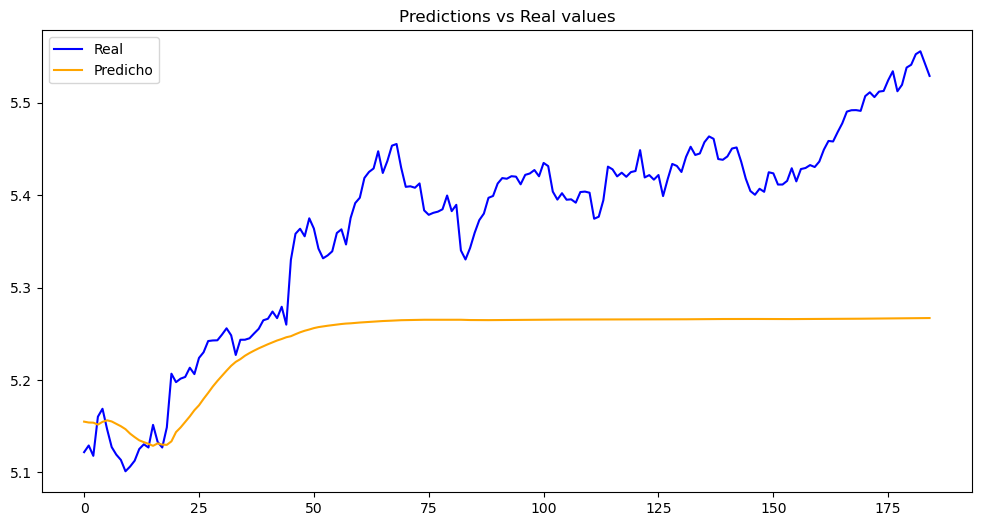

In [149]:
plot_predictions(y_test_true, y_pred_test)